# Initialization bya BNSE for SM kernel

Comparison between initializing sm kernel with different heuristics

* Random
* Lomb Scargle
* BNSE

In [1]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def get_param_across(model, name='mixture_means'):
    """
    Get all the name parameters across all components
    """
    params = [model.get_params()[q][name] for q in range(model.Q)]
    
    return np.array(params)

In [4]:
def experiment(x_train, y_train, x_pred, y_test, true_params, Q=3, n_trials=100):
    """
    Experiment with the 3 initializations for GP-SM
    
    The GP is fitted using the data and compared with the real
    parameters. This is done 'n_trial' times for each initialization 
    method.
    """
    # total error
    mae_param = np.zeros((3, n_trials))
    mae_pred = np.zeros((3, n_trials))
    
    x_pred = {0:x_pred}
    
    # create and train model
    data = mogptk.Data()
    data.add(x_train, y_train)
    
    init_methods = ['random', 'LS', 'BNSE']
    
    for i, method in enumerate(init_methods):
        for n in range(n_trials):
            # pick random seed
            seed = np.random.randint(1, int(1e8))
            np.random.seed(seed)
            
            model = mogptk.SM(data, Q=Q)
            model.init_params(method)
            model.train(maxiter=5000, disp=False)
            
            # param error
            means_pred = get_param_across(model, 'mixture_means').reshape(-1)
            mae_param[i, n] = np.abs(true_params - means_pred).sum()
            
            # pred error
            x_pred, y_pred, var_pred = model.predict(x_pred)
            mae_pred[i, n] = np.abs(y_test - y_pred[0]).mean()
            
    return mae_param, mae_pred

Create data for the experiment

In [5]:
# target freq to estimate
target_freqs = np.array([0.2, 1, 2])
target_amps = [1, 0.5, 0.5]

n_points = 500

t = np.linspace(0, 20, n_points)
y = np.zeros(n_points)

for i in range(3):
    y += target_amps[i] * np.sin(2 * np.pi * target_freqs[i] * t)
y_n = y + np.random.normal(scale=0.1, size=500)

# data class
data = mogptk.Data()

data.add(t, y_n, 'A')
data.remove_range('A', start=10.0, end=None)

In [6]:
# create model
model = mogptk.SM(data, Q=3)
# display(model.get_params())

In [7]:
seed = np.random.randint(1, int(1e8))
np.random.seed(seed)

# initialize params
model.init_params(method='LS')
# display(model.get_params())
print('Mixture means', get_param_across(model))

model.train(method='L-BFGS-B', maxiter=5000, disp=False)

Mixture means [[0.19462962]
 [2.00243788]
 [0.99809996]]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -204.867621
  Number of iterations: 275
  Number of functions evaluations: 351


Mixture means [[0.99448444]
 [1.9997333 ]
 [0.19935532]]


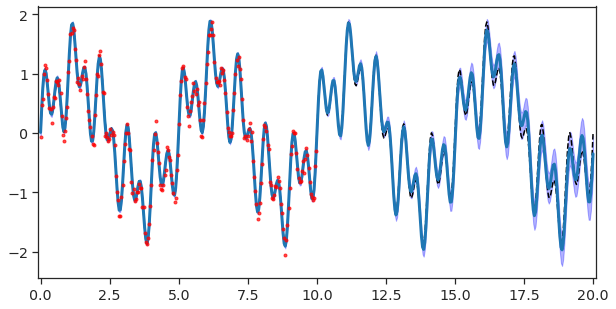

In [8]:
# x_pred = {0:np.linspace(0, 20, 300)}
x_pred = {0:t}
x_pred, y_pred, y_var = model.predict(x_pred)

print('Mixture means', get_param_across(model))

plt.plot(x_pred[0], y_pred[0], label='Pred', lw=3, zorder=2)
plt.plot(data.X[0], data.Y[0], '.r', alpha=0.7, zorder=2)
plt.plot(t, y, '--k', zorder=1)
plt.fill_between(x_pred[0],
                 y_pred[0] + 2 * np.sqrt(y_var[0]), 
                y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                alpha=0.3,
                zorder=1)
plt.xlim(-0.1, 20.1);

In [13]:
err_param, err_pred = experiment(t[:250], y_n[:250], t, y, target_freqs, Q=3, n_trials=50)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 200.234911
  Number of iterations: 33
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.019195
  Number of iterations: 74
  Number of functions evaluations: 86
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 321.639510
  Number of iterations: 29
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 200.235039
  Number of iterations: 34
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 199.981930
  Num

In [14]:
err_param.mean(1), err_param.std(1)

(array([10.39534861,  1.94837541,  0.30397016]),
 array([5.7475212 , 0.78490561, 0.67784935]))

In [15]:
err_pred.mean(1), err_pred.std(1)

(array([0.45166985, 0.03408532, 0.0429752 ]),
 array([0.11440229, 0.0672785 , 0.05970464]))


# Experiment 1: Mauna Loa

In [ ]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

In [ ]:
x, y = load_mauna_loa_atmospheric_co2()

stop = 300

plt.plot(x[:stop], y[:stop])
plt.plot(x[stop:], y[stop:], 'r')
plt.xlabel('Year')
plt.ylabel('CO2')

In [ ]:
# add data
data = mogp.Data()
data.add(x[:stop], y[:stop])

# create model
model = mogp.SM(data, Q=8)
# display(model.get_params())

In [ ]:
model.init_params('BNSE')
# display(model.get_params())

In [ ]:
model.train(method='L-BFGS-B', maxiter=5000, disp=False)

In [ ]:
x_pred = {0:x}
x_pred, y_pred, y_var = model.predict(x_pred)

In [ ]:
plt.plot(x, y, '--k', label='Data', lw=1, zorder=2)
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=1)
plt.fill_between(x_pred[0],
                 y_pred[0] + 2 * np.sqrt(y_var[0]), 
                y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                alpha=0.3,
                zorder=1)
plt.xlabel('Year')
plt.ylabel('CO2')

# Jura single output


Save for later (until multi input])

In [ ]:
jura = pd.read_csv('data/jura.csv')

In [ ]:
jura.head()

# Sunspots